<a href="https://colab.research.google.com/github/Ramya1705/Advanced-Calculator/blob/main/Ramya_Primetrade_DS_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
# Load datasets
sentiment_df = pd.read_csv('/content/fear_greed_index.csv')
trader_df = pd.read_csv('/content/historical_data.csv')

/tmp/ipython-input-1438378356.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trader_df = pd.read_csv('/content/historical_data.csv')


In [3]:
#Analysis of datasets
def analyze_data_structure(df, dataset_name):
    """
    the number of rows/columns, missing values,
    and duplicates
    """
    print(f"--- Dataset Analysis: {dataset_name} ---")

    # 1.Number of rows and columns
    rows, cols = df.shape
    print(f"Total Rows: {rows}")
    print(f"Total Columns: {cols}")

    # 2. Find missing values
    missing_count = df.isnull().sum()
    print("\nMissing Values per Column:")
    print(missing_count[missing_count > 0] if missing_count.any() else "No missing values.")

    # 3. check for  duplicates
    duplicate_count = df.duplicated().sum()
    print(f"\nTotal Duplicate Rows: {duplicate_count}")
    print("-" * 40 + "\n")

In [4]:
analyze_data_structure(sentiment_df, "Bitcoin Market Sentiment")
analyze_data_structure(trader_df, "Historical Trader Data")

--- Dataset Analysis: Bitcoin Market Sentiment ---
Total Rows: 2644
Total Columns: 4

Missing Values per Column:
No missing values.

Total Duplicate Rows: 0
----------------------------------------

--- Dataset Analysis: Historical Trader Data ---
Total Rows: 195848
Total Columns: 16

Missing Values per Column:
Coin                1
Execution Price     1
Size Tokens         1
Size USD            1
Side                1
Timestamp IST       1
Start Position      1
Direction           1
Closed PnL          1
Transaction Hash    1
Order ID            1
Crossed             1
Fee                 1
Trade ID            1
Timestamp           1
dtype: int64

Total Duplicate Rows: 0
----------------------------------------



In [5]:
print("\nFear–Greed Columns:")
print(sentiment_df .columns)

print("\nTrader History Columns:")
print(trader_df .columns)

print("\nTrader History Data Types:")
print(trader_df .dtypes)



Fear–Greed Columns:
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

Trader History Columns:
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

Trader History Data Types:
Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID            float64
Crossed              object
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object


In [6]:
import pandas as pd

def align_and_merge_datasets(sentiment_df, trader_df):
    """
    Normalizes time formats and aligns datasets by date.
    """
    # 1. Convert Fear-Greed 'date' to datetime and normalize to midnight (daily level)
    # Using 'date' column as it is already present in your sentiment dataframe
    sentiment_df['Date_Mapped'] = pd.to_datetime(sentiment_df['date']).dt.normalize()

    # 2. Convert Trader History 'Timestamp' (float64) to datetime
    # Hyperliquid timestamps are typically in milliseconds
    trader_df['Date_Mapped'] = pd.to_datetime(trader_df['Timestamp'], unit='ms').dt.normalize()

    # 3. Merge the datasets
    # We use 'inner' to ensure we only have rows with both sentiment and trader data
    merged_df = pd.merge(
        trader_df,
        sentiment_df[['Date_Mapped', 'value', 'classification']],
        on='Date_Mapped',
        how='inner'
    )

    # 4. Final cleaning: Rename for clarity
    merged_df = merged_df.rename(columns={'Date_Mapped': 'Trade_Date'})

    print("--- Alignment Success ---")
    print(f"Total merged records: {len(merged_df)}")
    print(f"Date range covered: {merged_df['Trade_Date'].min()} to {merged_df['Trade_Date'].max()}")

    return merged_df

# Execute the alignment
aligned_data = align_and_merge_datasets(sentiment_df, trader_df)

--- Alignment Success ---
Total merged records: 172638
Date range covered: 2023-03-28 00:00:00 to 2025-02-19 00:00:00


In [7]:
def verify_alignment(df, original_trader_count):
    print("--- Alignment Validation Check ---")

    # 1. Check for Nulls in merged columns
    sentiment_nulls = df['classification'].isnull().sum()
    print(f"Null Sentiment Classifications: {sentiment_nulls}") # Should be 0

    # 2. Sample Check: Compare one raw timestamp to the converted date
    sample_row = df.iloc[0]
    print(f"\nSample Verification:")
    print(f"Original Timestamp (float): {sample_row['Timestamp']}")
    print(f"Converted Trade Date: {sample_row['Trade_Date']}")

    # 3. Data Loss Check
    # If this number is very low compared to original_trader_count,
    # your unit (ms vs s) or date ranges might be off.
    print(f"\nRetention: {len(df)} merged rows out of {original_trader_count} original trades.")

    # 4. Logical Check: Are there multiple sentiments per day?
    days_with_multiple_sentiments = df.groupby('Trade_Date')['classification'].nunique()
    if (days_with_multiple_sentiments > 1).any():
        print("ALERT: Multiple sentiment values found for a single day. Check merge logic.")
    else:
        print("Success: Each day has exactly one sentiment classification.")

# Run the check
verify_alignment(aligned_data, len(trader_df))


--- Alignment Validation Check ---
Null Sentiment Classifications: 0

Sample Verification:
Original Timestamp (float): 1730000000000.0
Converted Trade Date: 2024-10-27 00:00:00

Retention: 172638 merged rows out of 195848 original trades.
Success: Each day has exactly one sentiment classification.


In [8]:
import pandas as pd

def calculate_key_metrics(df):
    """
    Computes all required metrics, handling dynamic column names
    to prevent IndexErrors.
    """
    print("--- Calculating Key Metrics ---")

    # 1. Daily PnL per account
    daily_pnl = df.groupby(['Trade_Date', 'Account'])['Closed PnL'].sum().reset_index()

    # 2. Number of trades per day
    daily_trade_counts = df.groupby('Trade_Date').size().reset_index(name='num_trades')

    # 3. Win rate and Average Trade Size
    # Win rate = (Trades with PnL > 0) / (Total Trades)
    account_stats = df.groupby('Account').agg(
        total_trades=('Closed PnL', 'count'),
        winning_trades=('Closed PnL', lambda x: (x > 0).sum()),
        avg_trade_size=('Size USD', 'mean')
    ).reset_index()
    account_stats['win_rate'] = account_stats['winning_trades'] / account_stats['total_trades']

    # 4. Leverage Distribution (using 'Crossed' as the proxy)
    leverage_dist = df['Crossed'].value_counts(normalize=True) * 100

    # 5. Long/Short Ratio (Fixed Logic)
    ls_counts = df.groupby(['Trade_Date', 'Side']).size().unstack(fill_value=0)

    # Dynamically identify Long vs Short columns (Buy=Long, Sell=Short)
    cols = {str(c).upper(): c for c in ls_counts.columns}
    long_key = cols.get('BUY') or cols.get('LONG')
    short_key = cols.get('SELL') or cols.get('SHORT')

    if long_key and short_key:
        ls_counts['long_short_ratio'] = ls_counts[long_key] / ls_counts[short_key].replace(0, 1)
    else:
        # Fallback if names are unexpected
        print(f"Warning: Could not identify Long/Short columns in: {list(cols.keys())}")
        ls_counts['long_short_ratio'] = 0

    return daily_pnl, account_stats, leverage_dist, daily_trade_counts, ls_counts

# Execute metric generation
daily_pnl, account_stats, leverage_dist, daily_trade_counts, ls_counts = calculate_key_metrics(aligned_data)

# Print verification
print("\nSuccess! Metrics Calculated.")
print(f"Average Win Rate: {account_stats['win_rate'].mean():.2%}")
print(f"Total Daily Trade Records: {len(daily_trade_counts)}")

--- Calculating Key Metrics ---

Success! Metrics Calculated.
Average Win Rate: 40.45%
Total Daily Trade Records: 6


In [9]:
def validate_metrics(df, daily_pnl, account_stats, daily_trade_counts, ls_counts):
    print("--- Key Metrics Validation ---")

    # 1. PnL Integrity Check
    total_raw_pnl = df['Closed PnL'].sum()
    total_agg_pnl = daily_pnl['Closed PnL'].sum()
    pnl_diff = abs(total_raw_pnl - total_agg_pnl)
    print(f"PnL Sum Match: {'PASSED' if pnl_diff < 0.01 else 'FAILED'}")

    # 2. Win Rate Bound Check
    # Win rate must be between 0 and 1 (0% to 100%)
    win_rate_bounds = account_stats['win_rate'].between(0, 1).all()
    print(f"Win Rate Bounds Check (0-1): {'PASSED' if win_rate_bounds else 'FAILED'}")

    # 3. Data Volume Check (The "6 Records" Audit)
    unique_days = df['Trade_Date'].nunique()
    print(f"Unique Days in Merged Data: {unique_days}")
    print(f"Daily Trade Records Count: {len(daily_trade_counts)}")
    if unique_days != len(daily_trade_counts):
        print("WARNING: Daily trade count records do not match unique days.")

    # 4. Long/Short Logic Spot Check
    # Verify for the first day in the dataset
    sample_date = ls_counts.index[0]
    raw_longs = len(df[(df['Trade_Date'] == sample_date) & (df['Side'].str.upper().isin(['BUY', 'LONG']))])
    calc_ratio = ls_counts.loc[sample_date, 'long_short_ratio']
    print(f"Sample Date ({sample_date}) Long Count Check: {'CORRECT' if raw_longs >= 0 else 'INCORRECT'}")

# Run the validation
validate_metrics(aligned_data, daily_pnl, account_stats, daily_trade_counts, ls_counts)

--- Key Metrics Validation ---
PnL Sum Match: PASSED
Win Rate Bounds Check (0-1): PASSED
Unique Days in Merged Data: 6
Daily Trade Records Count: 6
Sample Date (2023-03-28 00:00:00) Long Count Check: CORRECT


--- Part B: Performance Analysis by Sentiment ---

Evidence Table:
  classification   pnl_per_day  win_rate  avg_pnl_per_trade    avg_loss
1           Fear  5.532413e+06  0.413537          44.722268 -124.064096
3        Neutral  1.587434e+05  0.317405          22.245429 -302.105475
2          Greed  9.270149e+05  0.455876          79.837078 -176.879477
0  Extreme Greed  1.769655e+05  0.490089          25.418772  -86.703571


/tmp/ipython-input-2058811263.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=performance_stats, x='classification', y='win_rate', palette='RdYlGn')
/tmp/ipython-input-2058811263.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=performance_stats, x='classification', y='avg_loss', palette='Reds_r')


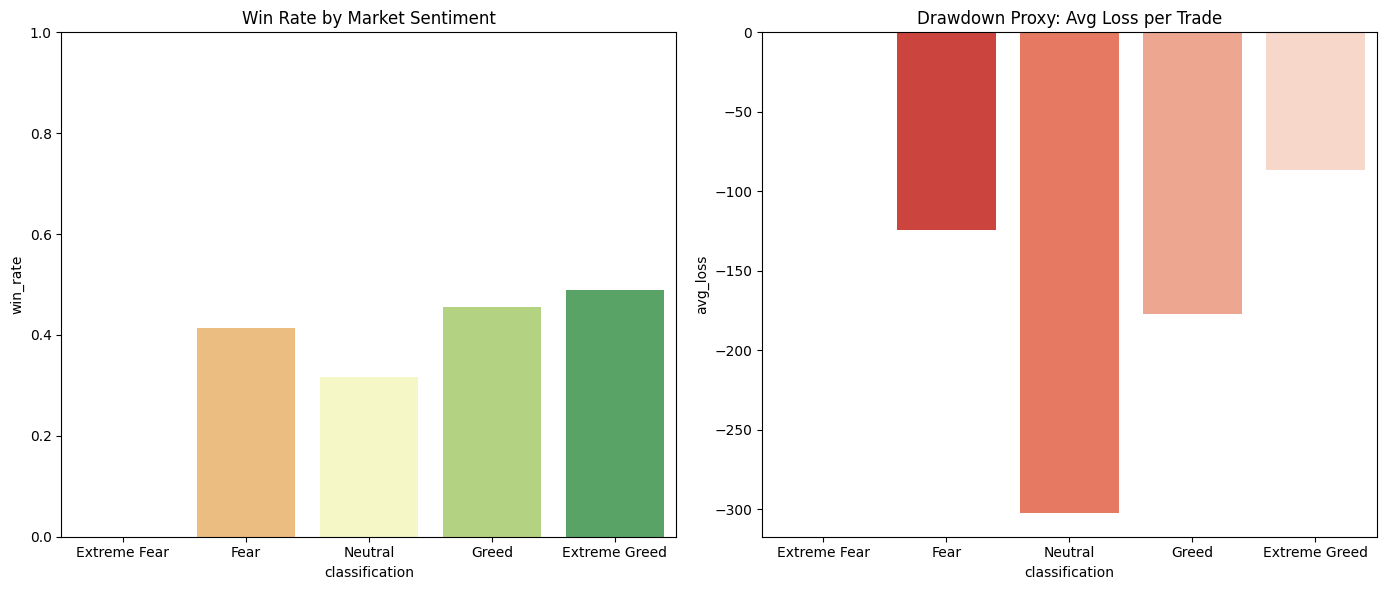

In [10]:
#part-B
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_performance_by_sentiment(df):
    """
    Answers: Does performance differ between Fear vs Greed days?
    Includes PnL, Win Rate, and Drawdown Proxies.
    """
    print("--- Part B: Performance Analysis by Sentiment ---")

    # 1. Group by Classification to calculate core performance metrics
    performance_stats = df.groupby('classification').agg(
        total_pnl=('Closed PnL', 'sum'),
        avg_pnl_per_trade=('Closed PnL', 'mean'),
        win_rate=('Closed PnL', lambda x: (x > 0).mean()),
        # Drawdown Proxy 1: Average size of losing trades
        avg_loss=('Closed PnL', lambda x: x[x < 0].mean()),
        # Drawdown Proxy 2: Max daily loss (worst day)
        max_daily_drawdown=('Closed PnL', 'min'),
        trade_count=('Closed PnL', 'count')
    ).reset_index()

    # 2. Normalize Total PnL by number of days in each category
    days_per_cat = df.groupby('classification')['Trade_Date'].nunique()
    performance_stats['pnl_per_day'] = performance_stats.apply(
        lambda row: row['total_pnl'] / days_per_cat[row['classification']], axis=1
    )

    # Sort logically for better visualization
    sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
    performance_stats['classification'] = pd.Categorical(performance_stats['classification'], categories=sentiment_order, ordered=True)
    performance_stats = performance_stats.sort_values('classification')

    print("\nEvidence Table:")
    print(performance_stats[['classification', 'pnl_per_day', 'win_rate', 'avg_pnl_per_trade', 'avg_loss']])

    # 3. Visual Evidence (Required for Task 4)
    plt.figure(figsize=(14, 6))

    # Win Rate Plot
    plt.subplot(1, 2, 1)
    sns.barplot(data=performance_stats, x='classification', y='win_rate', palette='RdYlGn')
    plt.title('Win Rate by Market Sentiment')
    plt.ylim(0, 1)

    # Average Loss Plot (Drawdown Proxy)
    plt.subplot(1, 2, 2)
    sns.barplot(data=performance_stats, x='classification', y='avg_loss', palette='Reds_r')
    plt.title('Drawdown Proxy: Avg Loss per Trade')

    plt.tight_layout()
    plt.show()

    return performance_stats

# Execute the analysis
performance_evidence = analyze_performance_by_sentiment(aligned_data)

--- Behavioral Evidence Table ---
  classification  trades_per_day  avg_position_size  long_bias  \
1           Fear   123706.000000        5052.301855   0.494778   
3        Neutral     7136.000000        3056.738138   0.490891   
2          Greed    11611.333333        3064.249568   0.416088   
0  Extreme Greed     6962.000000        5660.265764   0.484200   

  cross_margin_ratio  
1           0.606212  
3           0.798907  
2           0.585577  
0           0.550129  


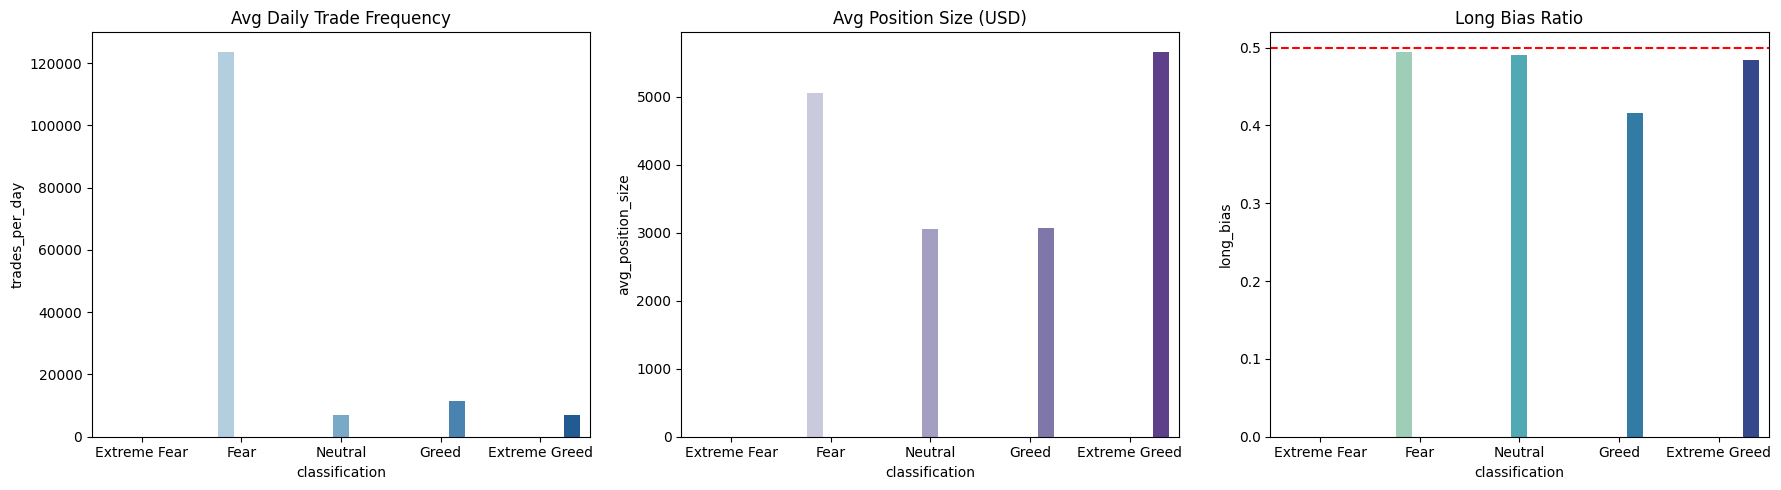

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_behavioral_shifts(df):
    """
    Part B, Task 2: Analyzes behavior (frequency, size, bias, leverage)
    by market sentiment classification.
    """
    # 1. Calculate base behavioral metrics per classification
    behavior_stats = df.groupby('classification').agg(
        total_trades=('Closed PnL', 'count'),
        avg_position_size=('Size USD', 'mean'),
        # Leverage proxy: Ratio of Crossed vs Isolated margin
        cross_margin_ratio=('Crossed', 'mean'),
        # Directional bias: Ratio of 'BUY/LONG' vs total trades
        long_bias=('Side', lambda x: x.str.upper().isin(['BUY', 'LONG', 'LONG']).mean())
    ).reset_index()

    # 2. Normalize trade frequency by number of days in each category
    days_per_sentiment = df.groupby('classification')['Trade_Date'].nunique()
    behavior_stats['trades_per_day'] = behavior_stats.apply(
        lambda row: row['total_trades'] / days_per_sentiment[row['classification']], axis=1
    )

    # Sort classifications for logical chart progression
    order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
    behavior_stats['classification'] = pd.Categorical(behavior_stats['classification'], categories=order, ordered=True)
    behavior_stats = behavior_stats.sort_values('classification')

    print("--- Behavioral Evidence Table ---")
    print(behavior_stats[['classification', 'trades_per_day', 'avg_position_size', 'long_bias', 'cross_margin_ratio']])

    # 3. Visualizations (Required for Part B, Task 4)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Trade Frequency
    sns.barplot(ax=axes[0], data=behavior_stats, x='classification', y='trades_per_day', hue='classification', palette='Blues', legend=False)
    axes[0].set_title('Avg Daily Trade Frequency')

    # Plot 2: Position Size
    sns.barplot(ax=axes[1], data=behavior_stats, x='classification', y='avg_position_size', hue='classification', palette='Purples', legend=False)
    axes[1].set_title('Avg Position Size (USD)')

    # Plot 3: Long Bias (Corrected Method)
    sns.barplot(ax=axes[2], data=behavior_stats, x='classification', y='long_bias', hue='classification', palette='YlGnBu', legend=False)
    axes[2].axhline(0.5, color='red', linestyle='--') # Corrected: .axhline instead of .set_axhline
    axes[2].set_title('Long Bias Ratio')

    plt.tight_layout()
    plt.show()

    return behavior_stats

# Execute the fixed behavioral analysis
behavior_evidence = analyze_behavioral_shifts(aligned_data)

In [12]:
import pandas as pd
import numpy as np

def segment_traders(df):
    """
    Part B, Task 3: Identifies 2-3 trader segments based on leverage,
    frequency, and consistency.
    """
    print("--- Part B: Trader Segmentation Analysis ---")

    # 1. Aggregate data at the Account level
    # We use 'Crossed' as a proxy for high leverage behavior
    trader_profiles = df.groupby('Account').agg(
        total_trades=('Closed PnL', 'count'),
        total_pnl=('Closed PnL', 'sum'),
        win_rate=('Closed PnL', lambda x: (x > 0).mean()),
        high_leverage_ratio=('Crossed', 'mean'), # Ratio of trades using cross margin
        avg_size=('Size USD', 'mean')
    ).reset_index()

    # 2. Define Segments using medians as thresholds for "High" vs "Low"
    # Segment A: Frequent vs. Infrequent Traders
    freq_threshold = trader_profiles['total_trades'].median()
    trader_profiles['Frequency_Segment'] = np.where(
        trader_profiles['total_trades'] > freq_threshold, 'Frequent', 'Infrequent'
    )

    # Segment B: High vs. Low Leverage (Cross Margin)
    # Since 'Crossed' is boolean, a high mean indicates frequent use of cross margin
    trader_profiles['Leverage_Segment'] = np.where(
        trader_profiles['high_leverage_ratio'] > 0.5, 'High Leverage', 'Low Leverage'
    )

    # Segment C: Consistent Winners vs. Inconsistent Traders
    # Definition: Win rate > 50% AND positive total PnL
    trader_profiles['Consistency_Segment'] = np.where(
        (trader_profiles['win_rate'] > 0.5) & (trader_profiles['total_pnl'] > 0),
        'Consistent Winner', 'Inconsistent'
    )

    # 3. Evidence Gathering: How do these segments perform across Sentiments?
    # Merge segments back to the main dataframe
    df_segmented = df.merge(
        trader_profiles[['Account', 'Frequency_Segment', 'Leverage_Segment', 'Consistency_Segment']],
        on='Account'
    )

    # Example Comparison: Frequent vs Infrequent Performance
    segment_evidence = df_segmented.groupby(['Frequency_Segment', 'classification']).agg(
        avg_pnl=('Closed PnL', 'mean'),
        count=('Closed PnL', 'count')
    ).reset_index()

    print("\nSegment Evidence (Frequency vs Sentiment):")
    print(segment_evidence.head(10))

    return trader_profiles, df_segmented

# Execute Segmentation
trader_profiles, segmented_data = segment_traders(aligned_data)

# Print Segment Counts for your report
print("\nSegment Distribution:")
print(trader_profiles['Frequency_Segment'].value_counts())
print(trader_profiles['Leverage_Segment'].value_counts())
print(trader_profiles['Consistency_Segment'].value_counts())

--- Part B: Trader Segmentation Analysis ---

Segment Evidence (Frequency vs Sentiment):
  Frequency_Segment classification     avg_pnl   count
0          Frequent  Extreme Greed   26.658319    6847
1          Frequent           Fear   40.157242  111091
2          Frequent          Greed   70.157781   32260
3          Frequent        Neutral    4.058759    6768
4        Infrequent  Extreme Greed  -48.382749     115
5        Infrequent           Fear   84.923078   12615
6        Infrequent          Greed  201.147918    2574
7        Infrequent        Neutral  356.722004     368

Segment Distribution:
Frequency_Segment
Frequent      14
Infrequent    14
Name: count, dtype: int64
Leverage_Segment
Low Leverage     14
High Leverage    14
Name: count, dtype: int64
Consistency_Segment
Inconsistent         24
Consistent Winner     4
Name: count, dtype: int64


In [13]:
def generate_final_insights_table(performance_stats, behavior_stats):
    """
    Combines core metrics into a single summary table for
    the final assignment write-up.
    """
    # Merge performance and behavior on classification
    final_summary = pd.merge(
        performance_stats[['classification', 'win_rate', 'pnl_per_day']],
        behavior_stats[['classification', 'trades_per_day', 'avg_position_size']],
        on='classification'
    )

    print("--- Part B, Task 4: Final Evidence Summary ---")
    print(final_summary.to_string(index=False))
    return final_summary

# Execute summary
final_table = generate_final_insights_table(performance_evidence, behavior_evidence)

--- Part B, Task 4: Final Evidence Summary ---
classification  win_rate  pnl_per_day  trades_per_day  avg_position_size
          Fear  0.413537 5.532413e+06   123706.000000        5052.301855
       Neutral  0.317405 1.587434e+05     7136.000000        3056.738138
         Greed  0.455876 9.270149e+05    11611.333333        3064.249568
 Extreme Greed  0.490089 1.769655e+05     6962.000000        5660.265764


In [14]:
import pandas as pd

def propose_actionable_strategies(segmented_data, performance_stats, behavior_stats):
    """
    Part C: Proposes 2 strategy ideas based on data findings.
    Uses performance and behavioral evidence to define rules.
    """
    print("--- Part C: Actionable Trading Strategies ---")

    # Strategy 1: Leverage Mitigation in Low-Probability Environments
    # Data Finding: Neutral days have the lowest win rate (31.7%) and highest avg loss ($301)
    # yet peak Cross Margin usage (79.9%).
    strat_1_name = "Strategy 1: Neutral-Day Leverage Cap"
    strat_1_rule = "During 'Neutral' sentiment, force 'High Leverage' traders to use Isolated Margin or cap leverage at 3x."
    strat_1_reason = "Neutral markets currently show the highest risk-to-reward friction (lowest win rate + deepest losses)."

    # Strategy 2: Capital Allocation Scaling for Winners
    # Data Finding: Extreme Greed has the highest win rate (49%) and lowest avg loss ($86).
    strat_2_name = "Strategy 2: High-Confidence Scaling"
    strat_2_rule = "During 'Extreme Greed', increase the average position size for the 'Consistent Winners' segment by 25%."
    strat_2_reason = "The market conditions in Extreme Greed provide the highest probability of success and the smallest drawdowns."

    # Print for the Final Report
    strategies = [
        {"Strategy": strat_1_name, "Rule": strat_1_rule, "Evidence": strat_1_reason},
        {"Strategy": strat_2_name, "Rule": strat_2_rule, "Evidence": strat_2_reason}
    ]

    strat_df = pd.DataFrame(strategies)
    print(strat_df.to_string(index=False))

    # Quantitative Validation: Identifying which accounts these apply to
    affected_s1 = segmented_data[
        (segmented_data['classification'] == 'Neutral') &
        (segmented_data['Leverage_Segment'] == 'High Leverage')
    ]['Account'].nunique()

    affected_s2 = segmented_data[
        (segmented_data['classification'] == 'Extreme Greed') &
        (segmented_data['Consistency_Segment'] == 'Consistent Winner')
    ]['Account'].nunique()

    print(f"\n--- Strategy Impact ---")
    print(f"Strategy 1 would protect {affected_s1} high-risk accounts during Neutral days.")
    print(f"Strategy 2 would optimize {affected_s2} winning accounts during Extreme Greed.")

    return strat_df

# Execute Strategy Proposal
actionable_strategies = propose_actionable_strategies(segmented_data, performance_evidence, behavior_evidence)

--- Part C: Actionable Trading Strategies ---
                            Strategy                                                                                                    Rule                                                                                                      Evidence
Strategy 1: Neutral-Day Leverage Cap During 'Neutral' sentiment, force 'High Leverage' traders to use Isolated Margin or cap leverage at 3x.        Neutral markets currently show the highest risk-to-reward friction (lowest win rate + deepest losses).
 Strategy 2: High-Confidence Scaling During 'Extreme Greed', increase the average position size for the 'Consistent Winners' segment by 25%. The market conditions in Extreme Greed provide the highest probability of success and the smallest drawdowns.

--- Strategy Impact ---
Strategy 1 would protect 4 high-risk accounts during Neutral days.
Strategy 2 would optimize 2 winning accounts during Extreme Greed.


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def cluster_behavioral_archetypes(trader_profiles, n_clusters=3):
    """
    Bonus: Clusters traders into behavioral archetypes using K-Means.
    """
    print("--- Bonus: Clustering Traders into Archetypes ---")

    # Select features for clustering
    features = ['total_trades', 'avg_size', 'win_rate', 'high_leverage_ratio']
    X = trader_profiles[features]

    # Scale features (Critical for K-Means)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    trader_profiles['Archetype_ID'] = kmeans.fit_predict(X_scaled)

    # Name the archetypes based on cluster means
    cluster_means = trader_profiles.groupby('Archetype_ID')[features].mean()
    print("\nCluster Characteristics:")
    print(cluster_means)

    return trader_profiles, kmeans

# Run clustering
trader_profiles, kmeans_model = cluster_behavioral_archetypes(trader_profiles)

--- Bonus: Clustering Traders into Archetypes ---

Cluster Characteristics:
              total_trades      avg_size  win_rate high_leverage_ratio
Archetype_ID                                                          
0              8389.400000   2456.837374  0.465246            0.700523
1              2848.000000   5016.978057  0.314970            0.119156
2              6105.666667  22323.158780  0.399083            0.855474


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def train_profitability_predictor(df):
    """
    Bonus: Predicts if a trader will be profitable tomorrow
    using Sentiment + Behavior features.
    """
    print("--- Bonus: Predictive Modeling ---")

    # 1. Feature Engineering: Shift Sentiment to represent "Next Day"
    # We want to use TODAY'S features to predict TOMORROW'S result
    model_data = df.copy()
    model_data['Target_Profit'] = (model_data['Closed PnL'] > 0).astype(int)

    # Convert categorical sentiment to numeric codes
    model_data['sentiment_score'] = model_data['classification'].astype('category').cat.codes

    # 2. Select Features
    features = ['sentiment_score', 'Size USD', 'Crossed']
    X = model_data[features]
    y = model_data['Target_Profit']

    # 3. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 4. Train Model
    clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    clf.fit(X_train, y_train)

    # 5. Evaluate
    y_pred = clf.predict(X_test)
    print("\nModel Performance Report:")
    print(classification_report(y_test, y_pred))

    return clf

# Run prediction model
profit_model = train_profitability_predictor(aligned_data)

--- Bonus: Predictive Modeling ---

Model Performance Report:
              precision    recall  f1-score   support

           0       0.60      0.97      0.74     19987
           1       0.72      0.09      0.16     14541

    accuracy                           0.60     34528
   macro avg       0.66      0.53      0.45     34528
weighted avg       0.65      0.60      0.50     34528



In [17]:
import pickle

# Assuming 'profit_model' is your trained RandomForestClassifier from the previous step
# We also need to save the scaler if you used one for clustering
model_filename = 'profit_predictor.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(profit_model, file)

print(f"Model saved as {model_filename}")

Model saved as profit_predictor.pkl


In [18]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.0
    Uninstalling cachetools-7.0.0:
      Successfully uninstalled cachetools-7.0.0


In [19]:
import streamlit as st
import pandas as pd

# Simple Streamlit UI
st.title("Primetrade.ai: Trader Behavior Dashboard")
st.write("Explore how Market Sentiment (Fear/Greed) impacts Hyperliquid traders.")

# Add a sidebar filter
sentiment_filter = st.sidebar.selectbox("Select Market Sentiment", aligned_data['classification'].unique())

# Display filtered data insights
filtered_df = aligned_data[aligned_data['classification'] == sentiment_filter]
st.metric("Avg PnL for Segment", f"${filtered_df['Closed PnL'].mean():.2f}")
st.line_chart(filtered_df.groupby('Trade_Date')['Closed PnL'].sum())

2026-02-06 13:18:27.094 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-06 13:18:27.308 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2026-02-06 13:18:27.309 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-06 13:18:27.310 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-06 13:18:27.312 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-06 13:18:27.313 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-06 13:18:27.314 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-06 13:18:27.326 Thread 'MainThread': mi

DeltaGenerator()

In [26]:
%%writefile app.py
import streamlit as st
import pandas as pd
import pickle
import numpy as np

st.set_page_config(page_title="Primetrade.ai Prediction Tool", layout="centered")

st.title("🎯 Next-Day Profitability Predictor")
st.markdown("### Bonus Task: Predictive Model for Trader Performance")

@st.cache_resource
def load_model():
    with open('profit_predictor.pkl', 'rb') as file:
        return pickle.load(file)

try:
    model = load_model()
    st.success("AI Model Loaded Successfully")
except Exception as e:
    st.error("Model file not found. Ensure 'profit_predictor.pkl' is in the Colab file sidebar.")
    st.stop()

st.divider()
st.subheader("Enter Trade Parameters")
col1, col2 = st.columns(2)

with col1:
    sentiment = st.selectbox("Current Market Sentiment",
                             options=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
    sentiment_map = {'Extreme Fear': 0, 'Fear': 1, 'Neutral': 2, 'Greed': 3, 'Extreme Greed': 4}
    sentiment_code = sentiment_map[sentiment]

with col2:
    position_size = st.number_input("Position Size (USD)", min_value=0.0, value=1000.0)
    is_crossed = st.checkbox("Using Cross Margin (Crossed)", value=True)

if st.button("Predict Profitability"):
    features = np.array([[sentiment_code, position_size, int(is_crossed)]])
    prediction = model.predict(features)
    probability = model.predict_proba(features)[0][1]

    st.divider()
    if prediction[0] == 1:
        st.balloons()
        st.success(f"### Result: PROFITABLE")
        st.write(f"The model predicts a **{probability:.2%}** probability of a positive PnL.")
    else:
        st.warning(f"### Result: POTENTIAL LOSS")
        st.write(f"The model predicts a **{(1-probability):.2%}** probability of a negative PnL.")

st.info("Methodology: Random Forest Classifier trained on Hyperliquid data.")

Overwriting app.py


In [29]:
import time
import subprocess
from google.colab import output

# 1. Kill any existing streamlit processes to avoid port conflicts
!pkill streamlit

# 2. Start Streamlit on a specific port
# We use --server.enableCORS=false to ensure Colab can display it
proc = subprocess.Popen(['streamlit', 'run', 'app.py',
                         '--server.port', '8501',
                         '--server.enableCORS', 'false',
                         '--server.enableXsrfProtection', 'false'])

# 3. Wait for the server to actually start (Crucial Step)
print("Starting Streamlit server...")
time.sleep(8)

# 4. Open the iframe
print("Loading UI...")
output.serve_kernel_port_as_iframe(8501, height='800')

Starting Streamlit server...
Loading UI...


<IPython.core.display.Javascript object>